# Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# Loading The Dataset

In [4]:
df = pd.read_csv('titanic.csv')

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploring Basic Info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Identifying Categorical and Numerical Columns

In [9]:
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if df[col].dtypes=='O':
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

print('The categorical columns are {}'.format(categorical_cols))
print('The numerical columns are {}'.format(numerical_cols))

The categorical columns are ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
The numerical columns are ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


### Checking null values

In [11]:
print('The following columns has missing values:')
print(' '*30)
for col in df.columns:
    if df[col].isnull().sum():
     print(f'The column {col} has {np.round(df[col].isnull().mean()*100,2)} % null values')

The following columns has missing values:
                              
The column Age has 19.87 % null values
The column Cabin has 77.1 % null values
The column Embarked has 0.22 % null values


### Checking Duplicates

In [13]:
print('The dataset has {} % duplicate rows'.format(df.duplicated().sum()*100/len(df)))

The dataset has 0.0 % duplicate rows


# Data Preprocessing

### Seperating train and test data

In [16]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Removing Unnecessary Columns

In [18]:
X_train.drop(columns={'PassengerId','Name','Ticket','Cabin'},axis=1,inplace=True)
X_test.drop(columns={'PassengerId','Name','Ticket','Cabin'},axis=1,inplace=True)

### Imputing the Values

In [20]:
age_imputer = KNNImputer(n_neighbors=5, weights='uniform')
embarked_imputer = SimpleImputer(strategy = 'most_frequent')

X_train['Age'] = age_imputer.fit_transform(X_train[['Age']]).ravel()
X_test['Age'] = age_imputer.transform(X_test[['Age']]).ravel()

X_train['Embarked'] = embarked_imputer.fit_transform(X_train[['Embarked']]).ravel()
X_test['Embarked'] = embarked_imputer.transform(X_test[['Embarked']]).ravel()

### Removing The Outliers

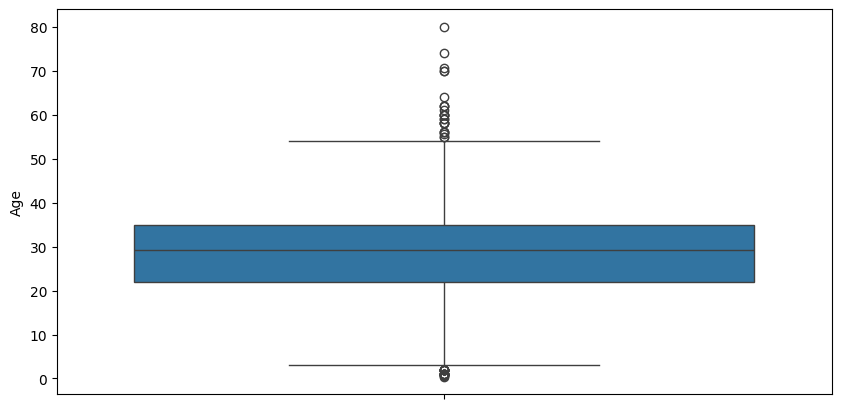

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(data=X_train,y='Age')
plt.show()

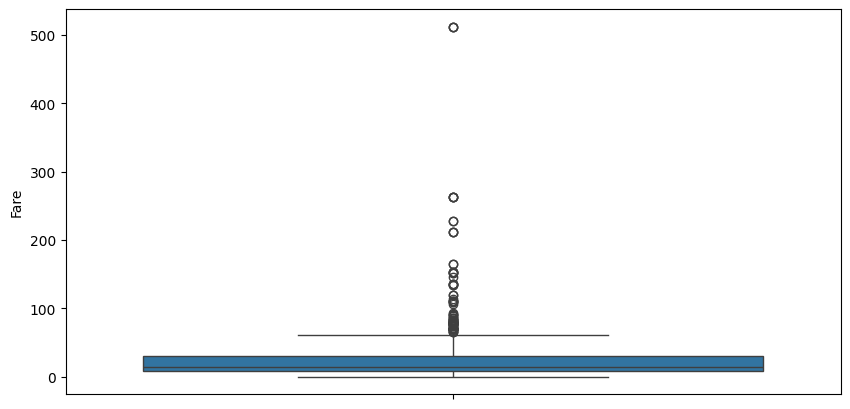

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(data=X_train,y='Fare')
plt.show()

In [24]:
def get_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

age_lower, age_upper = get_iqr_bounds(X_train['Age'])
fare_lower, fare_upper = get_iqr_bounds(X_train['Fare'])

X_train = X_train[(X_train['Age'] >= age_lower) & (X_train['Age'] <= age_upper)]
X_train = X_train[(X_train['Fare'] >= fare_lower) & (X_train['Fare'] <= fare_upper)]

X_test = X_test[(X_test['Age'] >= age_lower) & (X_test['Age'] <= age_upper)]
X_test = X_test[(X_test['Fare'] >= fare_lower) & (X_test['Fare'] <= fare_upper)]

### Encoding and Scaling The Data

In [26]:
categorical_cols = ['Sex','Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num',StandardScaler(),numerical_cols)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

### Converting to a dataframe

In [28]:
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

all_feature_names = list(ohe_feature_names) + numerical_cols

X_train_df = pd.DataFrame(X_train_encoded, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_encoded, columns=all_feature_names)

X_train_df.reset_index(drop=True, inplace=True)
X_test_df.reset_index(drop=True, inplace=True)